# <font color='#4CAF50'>Variational Autoencoder (VAE) Implementation using CNN and PyTorch</font>
**Author:** Vincent Paul  
**Email:** [vincentpaul.vin1990@gmail.com](mailto:vincentpaul.vin1990@gmail.com)  
**Date:** October 2024  

---

## **Project Description**
This notebook demonstrates the implementation of a **Variational Autoencoder (VAE)** using **Convolutional Neural Networks (CNNs)** and **PyTorch**, with the popular **MNIST** dataset for digit classification. The primary goal of this project is to illustrate deep learning techniques in generative modeling and provide practical insights into implementing a VAE for dimensionality reduction and data generation tasks.

---

## **Key Features of the Notebook**
1. **Variational Autoencoder (VAE) Model Implementation**
   - Encoder and decoder networks based on Convolutional Neural Networks (CNNs).
   - Kaiming Initialization (He Initialization) for weight initialization.

2. **Training and Evaluation**
   - Custom loss function for VAE: Binary Cross-Entropy (BCE) + KL Divergence.
   - Implementation of training, evaluation, and sampling loops with detailed performance metrics.

3. **Data Visualization**
   - Reconstruction of input images using the trained VAE.
   - Visualization of the **latent space** representation to explore data encoding.

4. **Sampling and Generative Modeling**
   - Sampling from the latent space to generate new MNIST digits.
   - 2D and 3D visualizations of multivariate Gaussian distributions.

---

## **Skills and Technologies Demonstrated**
- **Deep Learning Architectures**:
  - Variational Autoencoders (VAE)
  - Convolutional Neural Networks (CNNs)
- **Framework**: PyTorch
- **Datasets**: MNIST (handwritten digit dataset)
- **Visualization Tools**:
  - Matplotlib
  - Seaborn
- **Optimization**:
  - Adam Optimizer
  - Custom loss functions
- **Initialization**: Kaiming Initialization (He Initialization)

---

## **Sections in the Notebook**
1. **Introduction**
   - Overview of Variational Autoencoders and their applications.
   - Explanation of the tasks involved in this implementation.

2. **Data Preprocessing**
   - Loading and transforming the MNIST dataset.
   - Splitting the dataset into training, validation, and testing sets.

3. **Model Definition**
   - Implementation of the CNN-based VAE architecture.
   - Detailed explanation of the encoder, decoder, and latent space.

4. **Training Loop**
   - Custom training and validation loops.
   - Tracking and visualization of training and evaluation losses.

5. **Latent Space Analysis**
   - Visualization of the latent space representation.
   - Analysis of how MNIST digits are encoded in the latent space.

6. **Generative Modeling**
   - Sampling from the latent space to generate new digits.
   - Reconstruction of input images and their comparison with ground truth.

---

## **Evaluation Criteria**
The notebook showcases proficiency in the following:
- **Deep Learning Techniques**: Implementing VAE with CNNs.
- **Generative Modeling**: Sampling and visualizing the latent space.
- **Programming Skills**: Clear and modular code using PyTorch.
- **Visualization**: Effective use of plots to present results and insights.

---

## **Note**
This project is based on publicly available datasets and deep learning techniques. All sensitive and proprietary data, as well as code from real-world work, have been excluded to ensure confidentiality and compliance.

---




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Model Definition

In [2]:
# Implements Kaiming initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')


# Implements the VAE-CNN model
class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        self.h_dims = h_dims
        self.latent_dims = latent_dims


        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, self.h_dims[0], kernel_size=3, stride=2, padding=1), #14x14
            nn.ReLU(),
            nn.Conv2d(self.h_dims[0], self.h_dims[1], kernel_size=3, stride=2, padding=1), #7x7
            nn.ReLU()
        )

        self.enc_out = self.h_dims[1] * 7 * 7 # from encoder

        self.mean_layer = nn.Linear(self.enc_out, self.latent_dims)
        self.logvar_layer = nn.Linear(self.enc_out, self.latent_dims)

        self.reshape = nn.Linear(self.latent_dims, self.enc_out) # b4 decoder

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.h_dims[1], self.h_dims[0], 3,2,1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.h_dims[0], input_channels, 4,2,0),
            nn.Sigmoid(),
        )

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        std = logvar.mul(0.5).exp_()
        mu_size = mu.size()
        gaussian = torch.randn(mu_size)
        return mu + std * gaussian

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flattening to size [bs, 64x7x7]
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        z = self.reshape(z)
        z = z.view(z.size(0), self.h_dims[1], 7, 7) # Unflattening to [bs, 64, 7, 7]
        return self.decoder(z)

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        mean, log_var = self.encode(x)
        z = self.reparametrize(mean, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mean, log_var


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
model.apply(weights_init)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

torch.Size([1, 1, 28, 28])


# Dataset Loading

In [3]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 2
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [4]:
# Loading dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(mnist_train))
valid_size = len(mnist_train) - train_size
train_dataset, valid_dataset = random_split(mnist_train, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.61MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

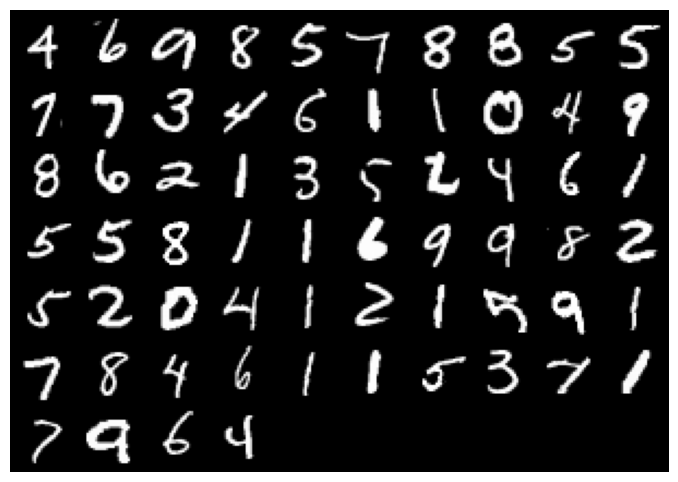

In [6]:
# TODO: Use the plot_image function to plot the images
img, _ = next(iter(train_loader))
plot_image(img)

# Training Loop

In [7]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    criterion = torch.nn.BCELoss(reduction='sum')
    reconstruction_loss = criterion(reconstructed_x, x)
    KLD = - 0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + KLD


In [8]:
# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
model.apply(weights_init) # Apply weights to the model

optimizer = optim.Adam(model.parameters(), lr=LR)
model = model.to(DEVICE)

train_losses = []
eval_losses = []
NUM_EPOCHS = 30


for epoch in range(NUM_EPOCHS):
    # Training loop
    model.train()
    train_loss = 0

    with tqdm(train_loader, unit="batch") as t_bar:
        for batch_idx, (data, _) in enumerate(t_bar):
            data = data.to(DEVICE)

            optimizer.zero_grad()
            reconstructed, mu, logvar = model(data)

            loss = vae_loss(reconstructed, data, mu, logvar)
            loss.backward()

            train_loss += loss.item()
            optimizer.step()

            t_bar.set_description(f'Training: Epoch {epoch+1}')
            t_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    val_loss = 0

    with tqdm(valid_loader, unit="batch") as v_bar:
        with torch.no_grad():
            for data, _ in v_bar:
                data = data.to(DEVICE)
                reconstructed, mu, logvar = model(data)

                loss = vae_loss(reconstructed, data, mu, logvar)
                val_loss += loss.item()

                v_bar.set_description('Validation')
                v_bar.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    eval_losses.append(avg_val_loss)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}: Train loss = {avg_train_loss:.4f}, Validation loss = {avg_val_loss:.4f}\n')

Validation: 100%|██████████| 188/188 [00:05<00:00, 31.62batch/s, loss=4114.75]


Epoch 1/30: Train loss = 190.3632, Validation loss = 132.5294



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.41batch/s, loss=3.89e+3]


Epoch 2/30: Train loss = 126.7800, Validation loss = 122.8582



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.78batch/s, loss=3.74e+3]


Epoch 3/30: Train loss = 120.6711, Validation loss = 118.8425



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.18batch/s, loss=3.6e+3]


Epoch 4/30: Train loss = 117.1755, Validation loss = 116.0112



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.40batch/s, loss=3.59e+3]


Epoch 5/30: Train loss = 114.6652, Validation loss = 114.1533



Validation: 100%|██████████| 188/188 [00:06<00:00, 28.48batch/s, loss=3.49e+3]


Epoch 6/30: Train loss = 112.8275, Validation loss = 112.1979



Validation: 100%|██████████| 188/188 [00:06<00:00, 30.39batch/s, loss=3.45e+3]


Epoch 7/30: Train loss = 111.4383, Validation loss = 111.1252



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.46batch/s, loss=3.49e+3]


Epoch 8/30: Train loss = 110.3377, Validation loss = 110.2446



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.53batch/s, loss=3.48e+3]


Epoch 9/30: Train loss = 109.4620, Validation loss = 109.2939



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.36batch/s, loss=3.42e+3]


Epoch 10/30: Train loss = 108.7674, Validation loss = 108.6564



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.57batch/s, loss=3.43e+3]


Epoch 11/30: Train loss = 108.1280, Validation loss = 108.2097



Validation: 100%|██████████| 188/188 [00:06<00:00, 30.36batch/s, loss=3.39e+3]


Epoch 12/30: Train loss = 107.6609, Validation loss = 107.8688



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.41batch/s, loss=3.4e+3]


Epoch 13/30: Train loss = 107.2924, Validation loss = 107.3443



Validation: 100%|██████████| 188/188 [00:06<00:00, 30.50batch/s, loss=3.35e+3]


Epoch 14/30: Train loss = 106.8928, Validation loss = 107.0166



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.78batch/s, loss=3.36e+3]


Epoch 15/30: Train loss = 106.5983, Validation loss = 106.8229



Validation: 100%|██████████| 188/188 [00:06<00:00, 31.24batch/s, loss=3.34e+3]


Epoch 16/30: Train loss = 106.2681, Validation loss = 106.5445



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.64batch/s, loss=3.34e+3]


Epoch 17/30: Train loss = 106.1118, Validation loss = 106.2199



Validation: 100%|██████████| 188/188 [00:06<00:00, 30.73batch/s, loss=3.32e+3]


Epoch 18/30: Train loss = 105.7956, Validation loss = 106.1034



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.52batch/s, loss=3.33e+3]


Epoch 19/30: Train loss = 105.6066, Validation loss = 106.0348



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.39batch/s, loss=3.35e+3]


Epoch 20/30: Train loss = 105.4190, Validation loss = 105.7769



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.32batch/s, loss=3.32e+3]


Epoch 21/30: Train loss = 105.2616, Validation loss = 105.5684



Validation: 100%|██████████| 188/188 [00:05<00:00, 32.76batch/s, loss=3.28e+3]


Epoch 22/30: Train loss = 105.0361, Validation loss = 105.3730



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.05batch/s, loss=3.37e+3]


Epoch 23/30: Train loss = 104.9016, Validation loss = 105.3534



Validation: 100%|██████████| 188/188 [00:05<00:00, 31.92batch/s, loss=3.3e+3]


Epoch 24/30: Train loss = 104.7840, Validation loss = 105.0507



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.54batch/s, loss=3.3e+3]


Epoch 25/30: Train loss = 104.5943, Validation loss = 104.9722



Validation: 100%|██████████| 188/188 [00:06<00:00, 29.32batch/s, loss=3.25e+3]


Epoch 26/30: Train loss = 104.4721, Validation loss = 105.0011



Validation: 100%|██████████| 188/188 [00:05<00:00, 35.07batch/s, loss=3.25e+3]


Epoch 27/30: Train loss = 104.3986, Validation loss = 104.8078



Validation: 100%|██████████| 188/188 [00:06<00:00, 29.84batch/s, loss=3.32e+3]


Epoch 28/30: Train loss = 104.2344, Validation loss = 104.7020



Validation: 100%|██████████| 188/188 [00:05<00:00, 34.87batch/s, loss=3.31e+3]


Epoch 29/30: Train loss = 104.1102, Validation loss = 104.7421



Validation: 100%|██████████| 188/188 [00:06<00:00, 30.70batch/s, loss=3.27e+3]

Epoch 30/30: Train loss = 103.9978, Validation loss = 104.4537



In [9]:
# Save the model
torch.save(model.state_dict(), f'model_{NUM_EPOCHS}epochs.pth')

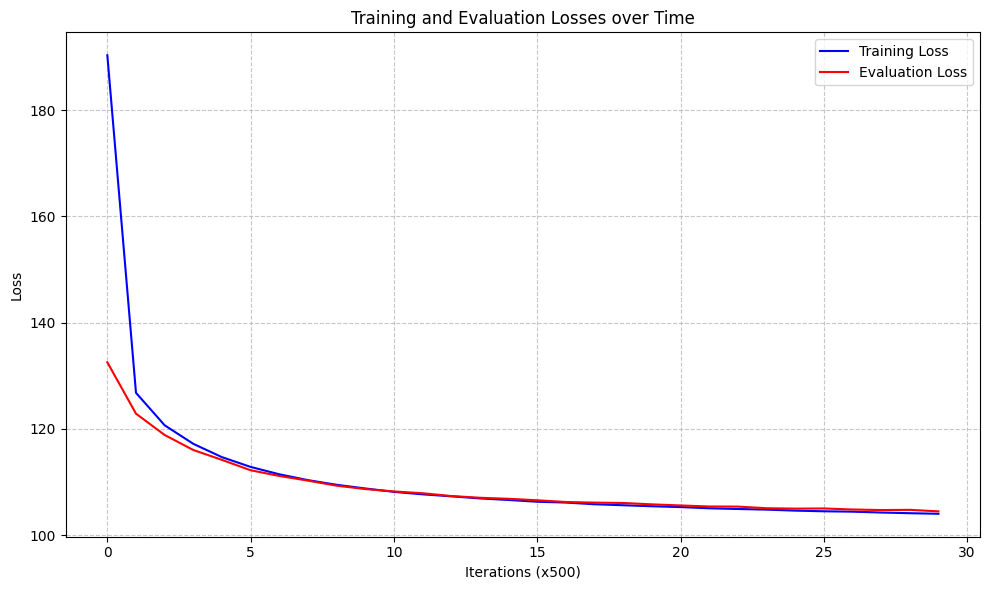

In [10]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

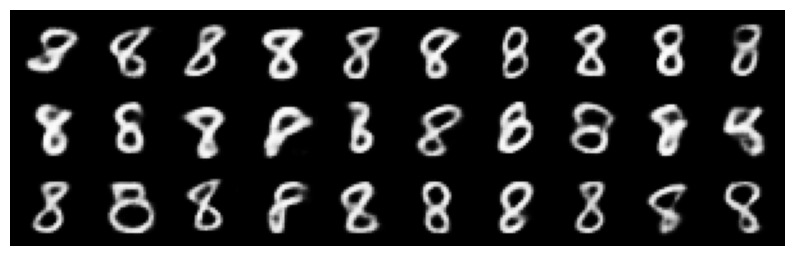

In [11]:
def visualize_generations(model, digit, num_examples):
    model.eval()

    digit_images = [img for img, label in mnist_test if label == digit]

    digit_images_tensor = torch.stack(digit_images)[:num_examples].to(DEVICE)

    with torch.no_grad():
        mu, logvar = model.encode(digit_images_tensor)

    std = torch.exp(0.5 * logvar)
    z_samples = mu + std * torch.randn_like(std)

    with torch.no_grad():
        reconstructed_images = model.decode(z_samples)

    plot_image(reconstructed_images)

# Usage
digit = 8
num_examples = 30
visualize_generations(model, digit, num_examples)


Shape of latents_m: torch.Size([10000, 20])


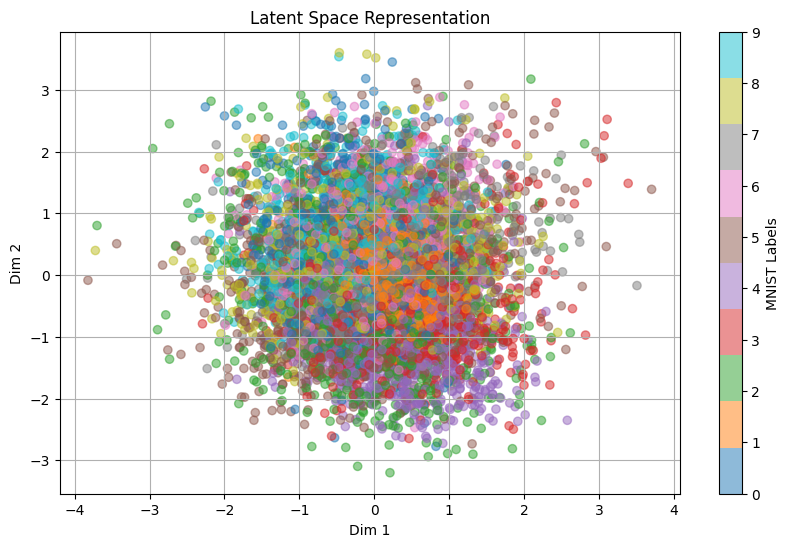

In [12]:
def visualize_latents(dataloader, model):
    model.eval()

    latents_m = []
    labels_m = []

    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(DEVICE)
            _, mu, logvar = model(data)

            latents_m.append(mu.cpu())
            labels_m.append(labels.cpu())

    latents_m = torch.cat(latents_m)
    labels_m = torch.cat(labels_m)

    print(f"Shape of latents_m: {latents_m.shape}")

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(latents_m[:, 0], latents_m[:, 1], c=labels_m, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter, label='MNIST Labels')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')
    plt.title('Latent Space Representation')
    plt.grid()
    plt.show()

# Usage
visualize_latents(test_loader, model)


In [13]:
# End of code